https://aviris.jpl.nasa.gov/dataportal/

In [1]:
import requests
import tarfile
import re
import numpy as np
import torch
from torchvision import transforms
from IPython.display import display
# from datasets import Dataset, concatenate_datasets, load_dataset

In [2]:
def is_header(filename):
    return filename.endswith('_img.hdr')
def is_data(filename):
    return filename.endswith('_img')
def get_size(header):
    nsamp_match = re.search(r"samples\s*=\s*(\d+)", header)
    nlines_match = re.search(r"lines\s*=\s*(\d+)", header)
    nbands_match = re.search(r"bands\s*=\s*(\d+)", header)
    nsamp = int(nsamp_match.group(1))
    nlines = int(nlines_match.group(1))
    nbands = int(nbands_match.group(1))
    return nsamp, nlines, nbands
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t
def visualize_hyper(x):
    z = torch.tensor(x[[20,100,180],:,:])
    z = z.to(torch.float)
    z = z - z.mean()
    z = 3 * z / z.std()
    z = torch.clamp(z,min=-3,max=3)
    z = z / 6
    display(transforms.ToPILImage()(pt_to_pil(z)))
def is_empty(x):
    z = torch.tensor(x)
    z = z.to(torch.float)
    z = z - z.mean()
    z = 3 * z / z.std()
    z = torch.clamp(z,min=-3,max=3)
    z = z / 6
    empty = False
    if (z.std()<0.3 or torch.isnan(z.std())):
        empty = True
    return empty

In [3]:
url_list = [
    'https://popo.jpl.nasa.gov/avcl/y10_data/f100829t01p00r05.tar.gz',
    'https://popo.jpl.nasa.gov/avcl/y11_data/f110523t01p00r16.tar.gz',
    'https://popo.jpl.nasa.gov/avcl/y11_data/f111116t01p00r21.tar.gz'
]

In [4]:
%%time
for url in url_list:
    try:
        # response = requests.get(url)
        # with open(url[-23:], 'wb') as f:
        #     f.write(response.content)
        with tarfile.open(url[-23:], 'r:gz') as tar:
            names = tar.getnames()
            header = next(filter(is_header, names), None)   
            header = tar.extractfile(header)
            header = header.read().decode('utf-8')
            nsamp, nlines, nbands = get_size(header)
            shape = (nlines, nsamp, nbands)
            dtype = np.int16
            data = next(filter(is_data, names), None)
            x = tar.extractfile(data).read()
            x = np.frombuffer(x, dtype=dtype)
            x = x.reshape(shape)
            x = x.transpose((2,0,1))
            # dataset.append(Dataset.from_dict({"image":[x]}))
            break
    except:
        pass

CPU times: user 13.8 s, sys: 491 ms, total: 14.3 s
Wall time: 14.3 s


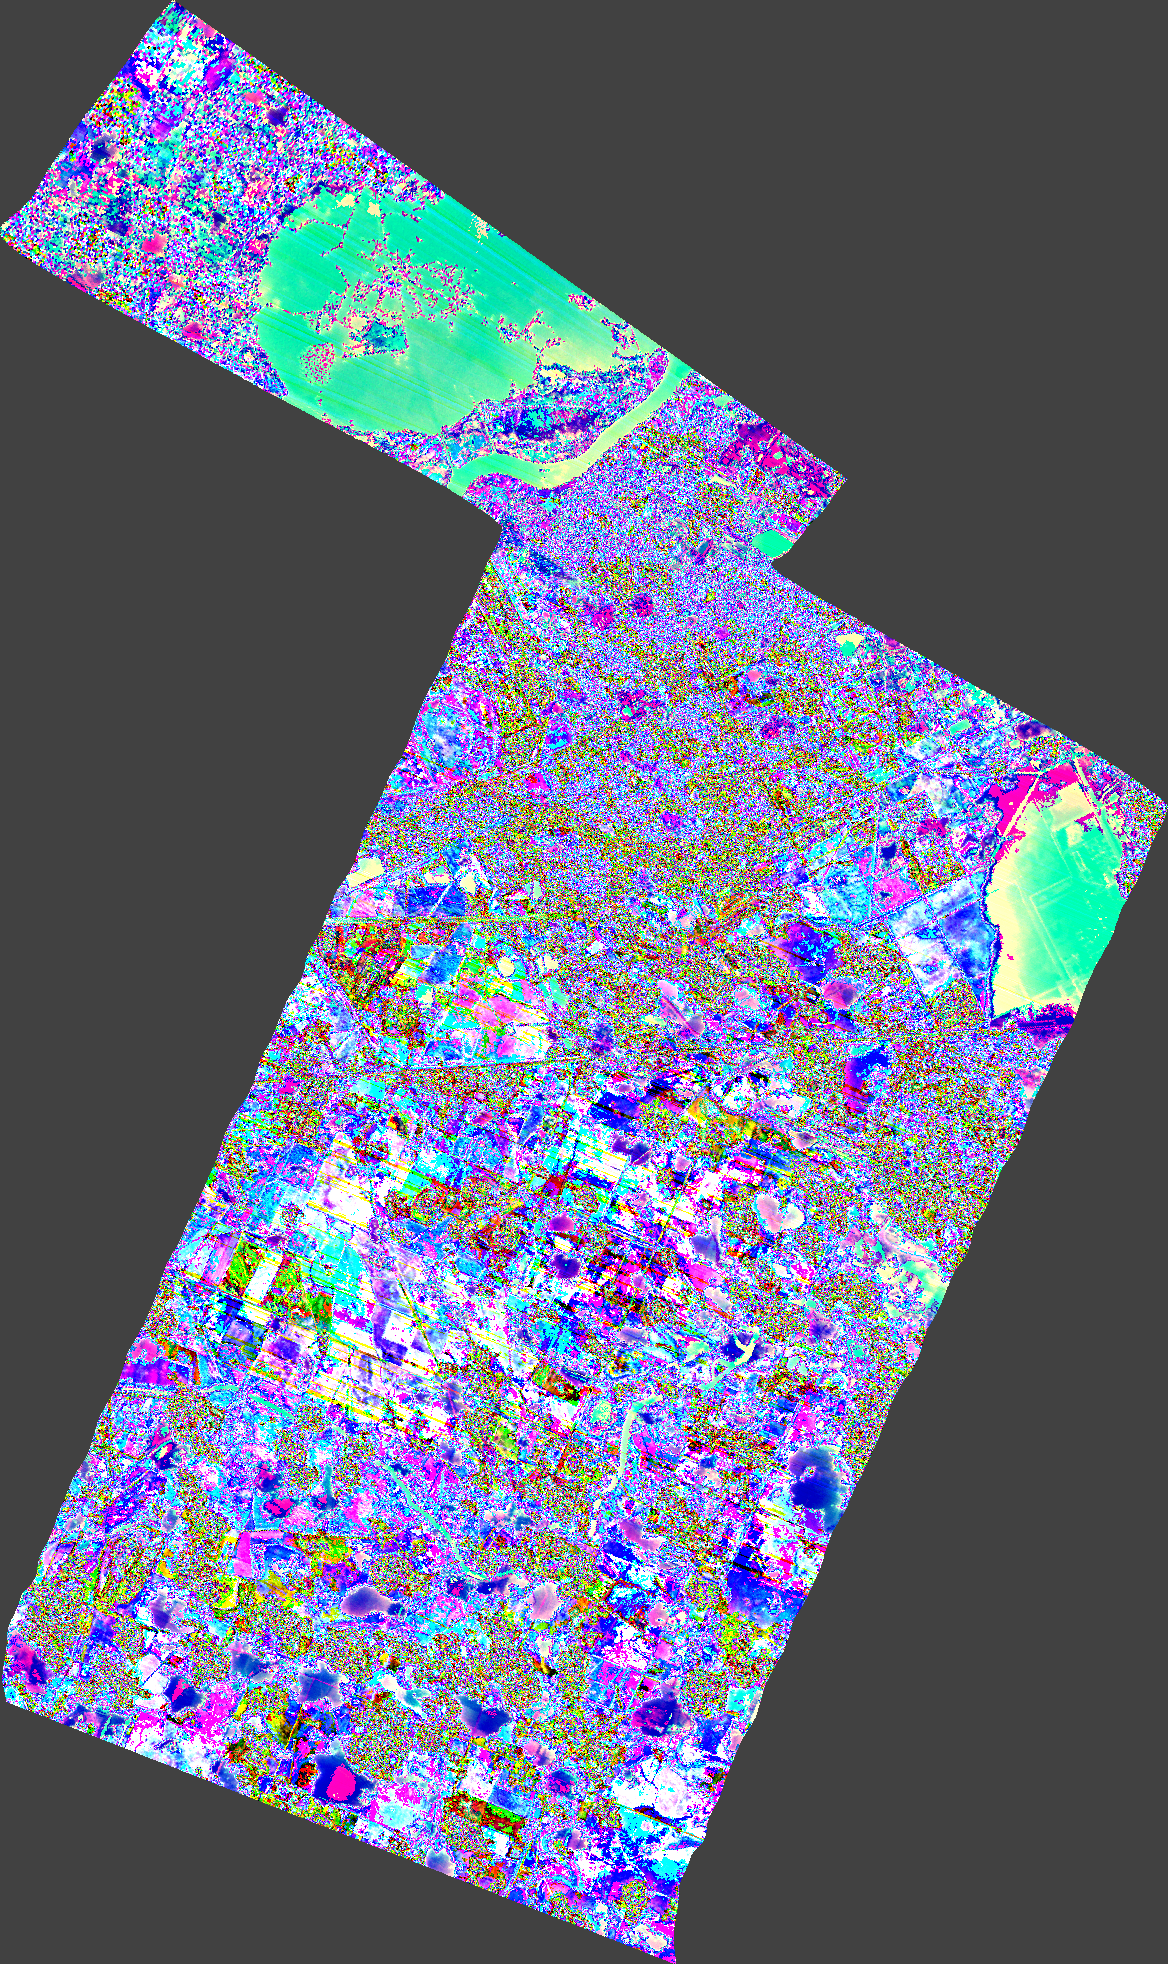

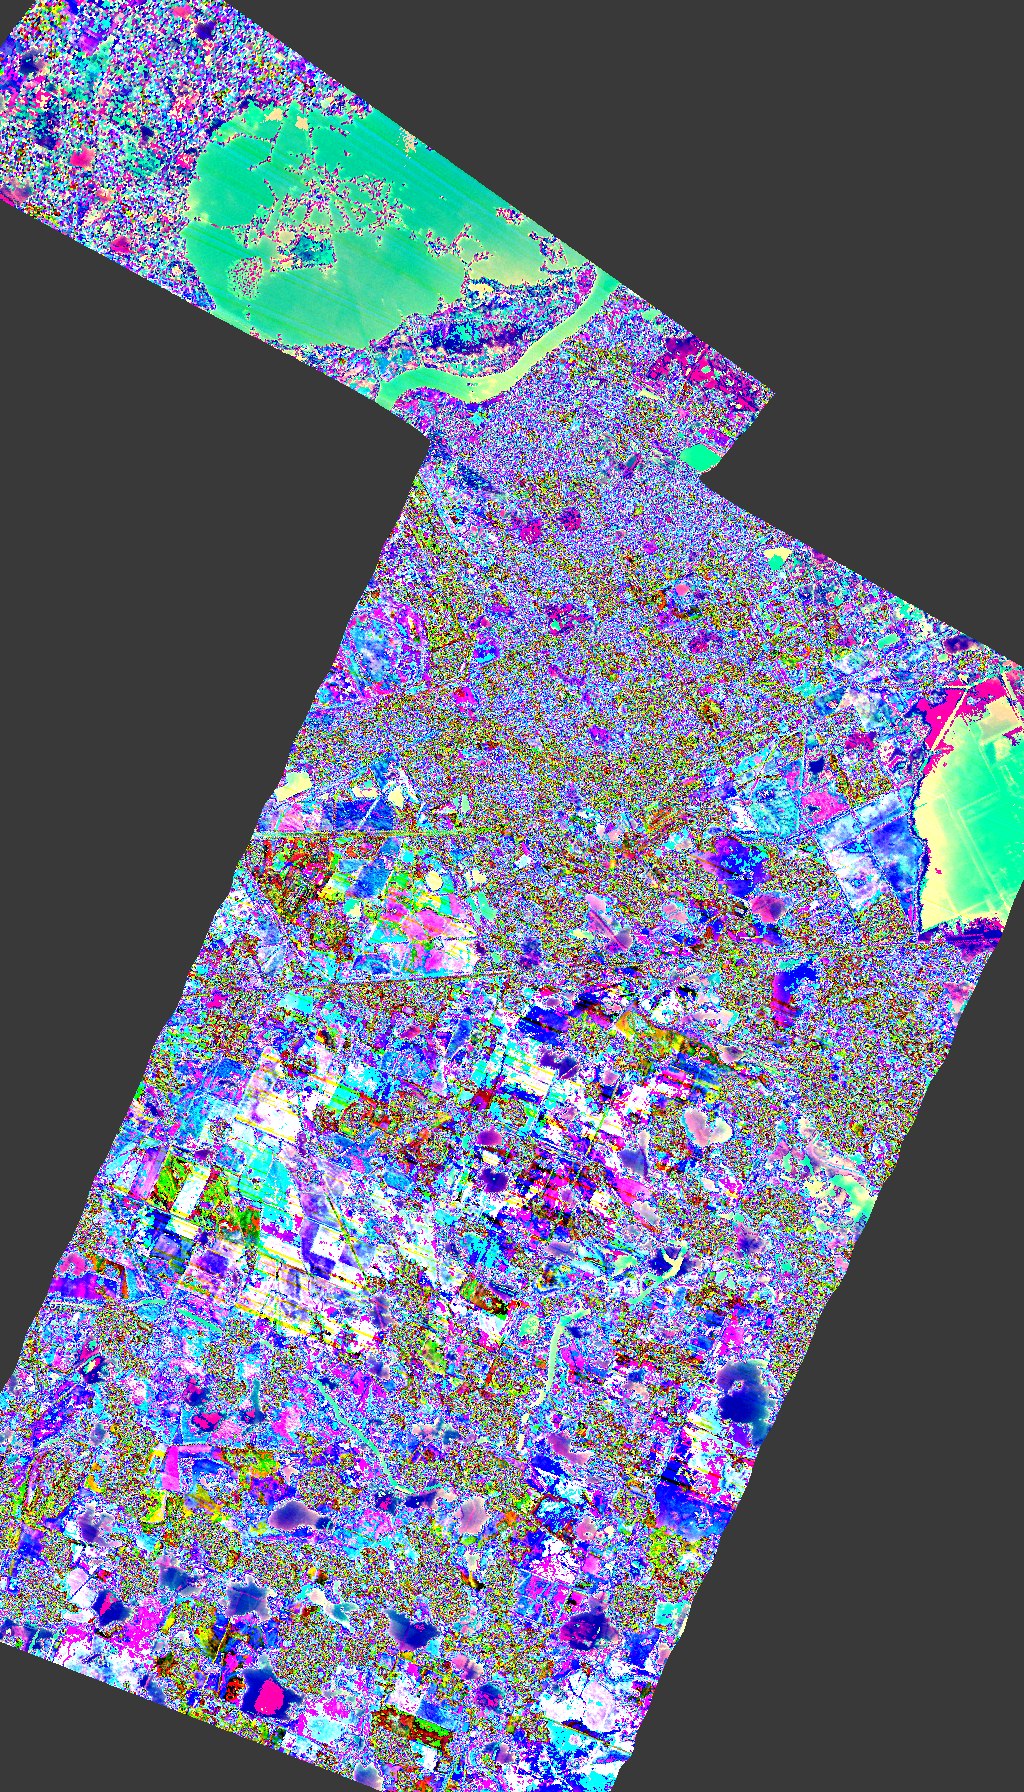

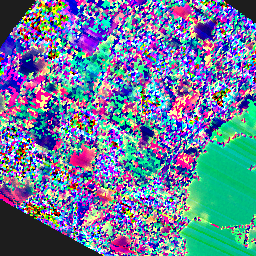

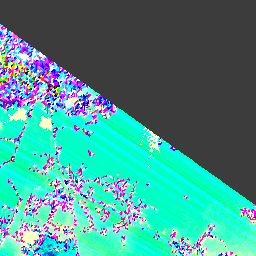

mostly empty


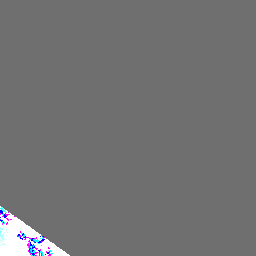

mostly empty


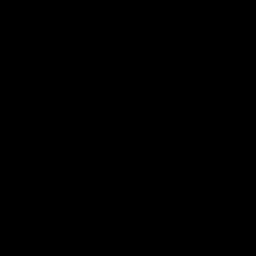

mostly empty


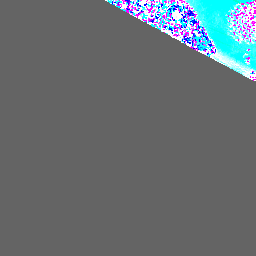

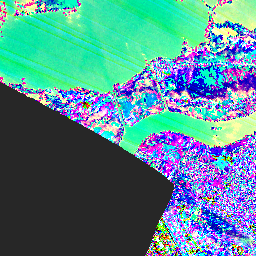

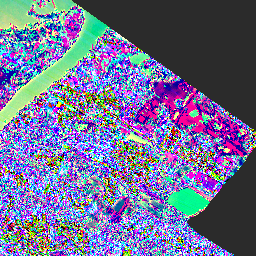

mostly empty


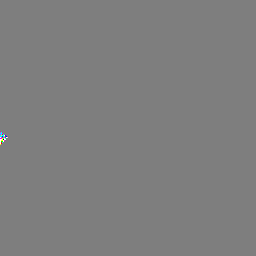

mostly empty


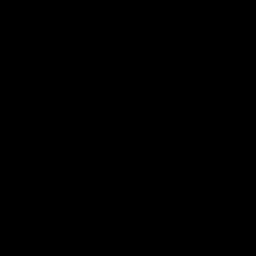

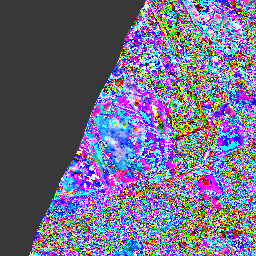

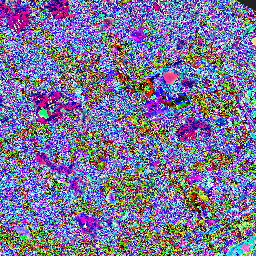

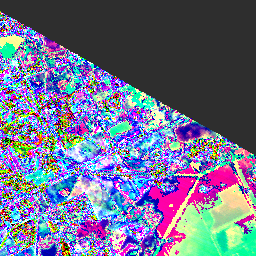

mostly empty


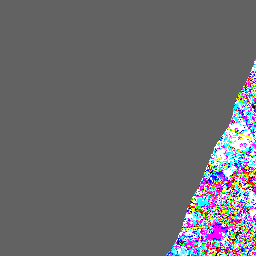

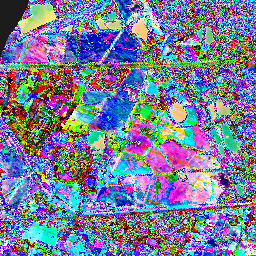

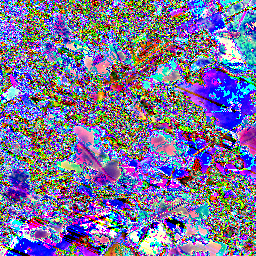

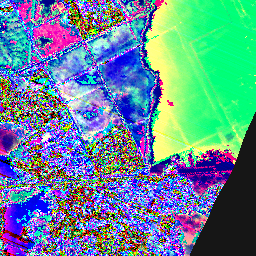

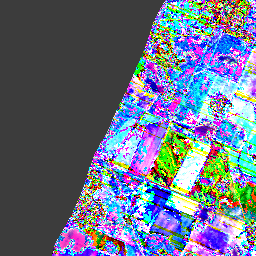

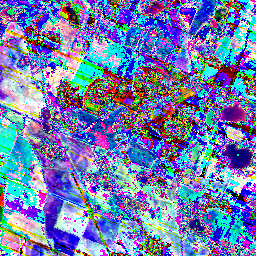

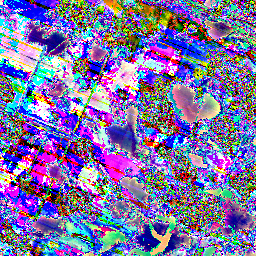

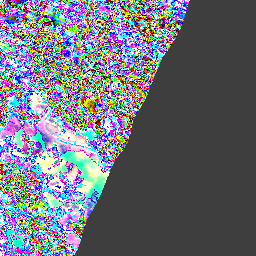

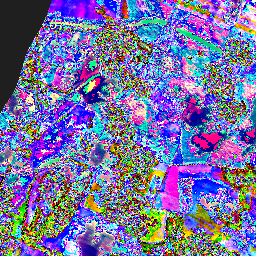

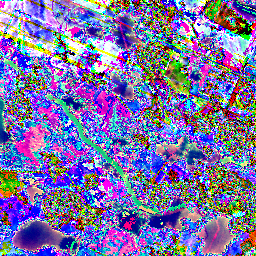

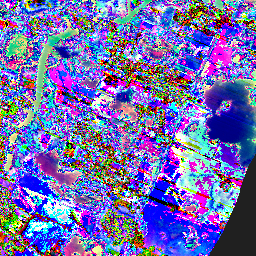

mostly empty


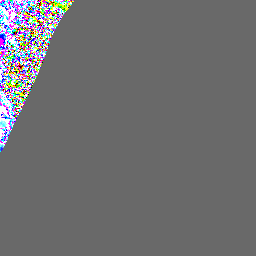

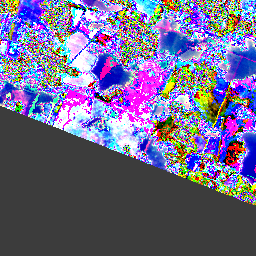

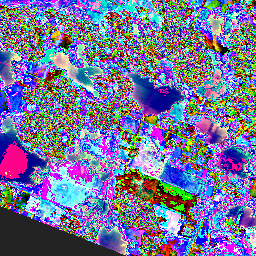

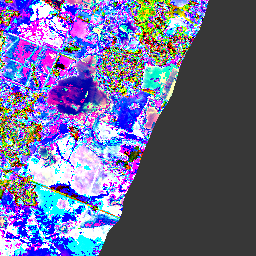

mostly empty


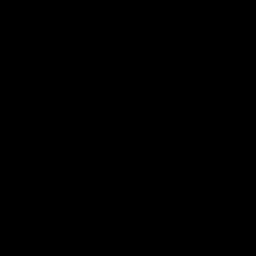

In [5]:
visualize_hyper(x)

C, H, W = x.shape
new_H = (H // 256) * 256
new_W = (W // 256) * 256
start_H = (H - new_H) // 2
start_W = (W - new_W) // 2
y = x[:, start_H:start_H + new_H, start_W:start_W + new_W]

visualize_hyper(y)

tiles = []
for h in range(0, new_H, 256):
    for w in range(0, new_W, 256):
        tile = y[:, h:h+256, w:w+256]
        tiles.append(tile)

for tile in tiles:
    if is_empty(tile):
        print("mostly empty")
    visualize_hyper(tile)